<a href="https://colab.research.google.com/github/AJ-21cm/AJ-21cm/blob/main/EE_DTRW_Synthetic_PlanarNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from sklearn import preprocessing,svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
import math as m
import pickle
from collections import OrderedDict

#Defining function for plotting work

In [ ]:
def scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=5,opacity=0.6,marker="o"):
  plt.scatter(xarr,yarr,s=dotsize, c=None, marker=None, cmap=None, norm=None,
  vmin=None, vmax=None, alpha=opacity, linewidths=None, edgecolors=None, plotnonfinite=False, data=None)
  #plt.plot(xarr,yarr,label=labels,ls=":")
  plt.grid()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()
def Box_Plot(xrr,xlabel,ylabel,title,label):
  plt.title(title)
  plt.boxplot(xarr,showmeans=True,  labels=label,notch=None, sym=None, vert=None, whis=None, positions=None, widths=None)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()
def HistoGram(array,bins,normalized,width,xlabel,ylabel,alingm,title,fsize):
  fig=plt.figure(figsize=fsize)
  plt.hist(array, bins=bins, range=None, density=normalized, weights=None, cumulative=False,
  bottom=None, histtype='bar', align=alingm, orientation='vertical', rwidth=width,
  log=False, color=None, label=None, stacked=False)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.grid()
def XY_plotting(x,y,xlabel,ylabel,title,linestyle,linewidth,color):
  plt.plot(x,y,ls=linestyle,lw=linewidth,c=color)
  plt.grid()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
def plotting_walker_time(degree,TimeS_dict,node):
  #degre=G.degree[a]
  node_timeS=TimeS_dict[node]
  l=np.array(node_timeS)
  #print(l.shape)
  plt.ylim(0,np.max(l[::,1])+10)
  plt.scatter(l[::,0],l[::,1],s=3,c=None, marker=None, cmap=None,
              norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=None, plotnonfinite=False, data=None)
  plt.xlabel("Time(s)")
  plt.ylabel("Number of Walkers")
  plt.title("Variation of Number of walkers with continous\n time on a node of degree "+str(degree))
  #print("total numbers of walkers % passes in time %"%(sum(l[::,0]),max(l[::,1])))
  #plt.yticks([i for i in range(m.ceil(max(l[::,1])))])
  #print(l)
  plt.show()
  #-----------------------------------------
  plt.title('Box plot')
  plt.boxplot(l[::,1],showmeans=True,  labels=None,notch=None, sym=None, vert=None, whis=None, positions=None, widths=None)
  plt.ylabel("Number of walkers")
  plt.grid()
  plt.show()

#Defining function for writing and reading data from a binary file

In [ ]:
def storeData(db,file_name):
    # Its important to use binary mode
    dbfile = open(file_name, 'wb')
    # source, destination
    pickle.dump(db, dbfile)
    dbfile.close()
def loadData(file_name):
    # for reading also binary mode is important
    dbfile = open(file_name, 'rb')
    db = pickle.load(dbfile)
    dbfile.close()
    return db

#Function defined for Curve Fitting

In [ ]:
def objective(x, a, b,c):
	return (a * x**b) + c
def curve_fitting(x,y):
  # curve fit
  popt, _ = curve_fit(objective, x, y)
  # summarize the parameter values
  a, b, c= popt
  # plot input vs output
  plt.scatter(x, y,label="simulation")
  # define a sequence of inputs between the smallest and largest known inputs
  x_line = np.arange(min(x), max(x), 1)
  # calculate the output for the range
  y_line = objective(x, a, b,c)
  print("scaling=",a,"exponent=",b,"shifting=",c)
  # create a line plot for the mapping function
  plt.plot(x, y_line, '--', color='red',label="Fitted")
  plt.legend()
  plt.show()

##Linear Regression using Sklearn Library

In [ ]:
def LinearR_sklearn(xarr,yarr):
  regr = LinearRegression()
  x=xarr.reshape(-1, 1)
  y=yarr.reshape(-1,1)
  regr.fit(x, y)
  y_pred = regr.predict(x)
  slope=np.round(regr.coef_[0,0],1)
  intercepts=np.round(regr.intercept_[0],1)
  #R_2=r2(y,y_pred)
  RMSE=m.sqrt(mse(y,y_pred))
  return y_pred,slope,intercepts#,R_2,RMSE

#Defining a function for creating GT model

In [ ]:
def GT_model_graph(l,t):
    w=2*l+1
    G=nx.grid_2d_graph(w,w,periodic=False, create_using=None)
    #nx.draw(G,with_labels=True)
    G_=nx.convert_node_labels_to_integers(G)
    x=[l,l*(w+1)-l,l*(w+1)+l,l*2*(w+1)-l]
    print(x)
    edge_conn=[(x[0],100*x[0]),(x[1],100*x[1]),(x[2],100*x[2]),(x[3],100*x[3])]
    print(edge_conn)
    edge_tree=[]
    for k in x:
      h=k*100
      for i in range(t+1):
          for j in range(i+1,i+3):
              edge_tree.append((h+i,h+i+j))
    edge_list=[*edge_tree,*edge_conn]
    tree_nodes=len(edge_list)
    G_.add_edges_from(edge_list)
    G_1=nx.convert_node_labels_to_integers(G_)
    return G_1,tree_nodes

#Functions defined for categorizing nodes of same degree

In [ ]:
def plotting_degree_distribution(nodes_degrees):
  nodes_degreewiseFrequency=[]
  for i in nodes_degrees:
   nodes_degreewiseFrequency.append([i[0],len(i[1])])
  nodes_degreewiseFrequency=np.array(nodes_degreewiseFrequency)
  fig=plt.figure(figsize=(10,5))
  plt.bar(nodes_degreewiseFrequency[::,0],nodes_degreewiseFrequency[::,1])
  plt.xlabel("Degrees")
  plt.ylabel("Frequency")
  plt.title("Degree Distribution")
  #plt.xticks([i for i in range(5,130,5)])
def nodes_with_same_Degree(node_Degree_dict):
  Degrees=list(set(node_Degree_dict.values()))
  nodes_degree=[]
  for i in Degrees:
    x=[]
    for j,k in node_Degree_dict.items():
      if i==k:
         x.append(j)
    nodes_degree.append([i,x])
  return nodes_degree

In [ ]:
#defining a function that gives the next position of a walker
def adjacency_list_nodeDegree(G,nodes):
  adjacency_list={i:[j for j in G.neighbors(i)] for i in range(nodes)}
  node_Degree_dict={i:len(adjacency_list[i]) for i in adjacency_list}
  return adjacency_list,node_Degree_dict
def next_pos(adjacency_list,node_Degree_dict,pos,alpha=0):
  neig=adjacency_list[pos]
  Deg_arr=np.array([node_Degree_dict[i] for i in neig],dtype=float)
  Deg_arr_=np.power(Deg_arr,alpha)
  prob=[j/sum(Deg_arr_) for j in Deg_arr_]
  next_pos=np.random.choice(neig,size=None, replace=True, p=prob)
  return next_pos
#numbers of walkers on a particular node at different time
#row represents the  descrete time
#Column represents the nodes
def DTRW_Time_Series(adjacency_list,node_Degree_dict,num_walkers,time,nodes,alpha):
  walkers_pos_trac=np.zeros((time,num_walkers))
  walkers_init_pos=np.random.randint(0,int(nodes),int(num_walkers))#initial position of a walkers
  walkers_pos_trac[0,::]=walkers_init_pos
  for j in range(num_walkers):
    for i in range(time):
      if i==time-1:
          break
      k=next_pos(adjacency_list,node_Degree_dict,walkers_pos_trac[i,j],0)
      walkers_pos_trac[i+1,j]=k
  num_wal_nodes_=np.zeros((time,nodes))
  for i in range(time):
      for j in range(0,nodes):
          m=walkers_pos_trac[i,::]
          c=np.count_nonzero(m==j)
          num_wal_nodes_[i,j]=c
  Time_series_nodewise_dict={}
  for node in range(nodes):
    Time_series_nodewise_dict[node]=num_wal_nodes_[::,node]
  return Time_series_nodewise_dict
def mean_std_walkers_nodewise(time_series_each_node,nodes):
  dic_mean_walkers={}
  dic_std_walkers={}
  for node in range(nodes):
    new_array=np.array(time_series_each_node[node])
    dic_mean_walkers[node]=np.mean(np.array([i for i in new_array ]))
    dic_std_walkers[node]=np.std(np.array([i for i in new_array]))
  return dic_mean_walkers,dic_std_walkers
#----------------------------------------------------------------------------------------------------------------
def walkers_statistic_degreewise(nodes_degrees,dic_mean_walkers ,dic_std_walkers):
  dic_meanW_PER_node_degreewise={}
  dic_stdW_PER_node_degreewise={}
  for nodes in nodes_degrees:
    deg=nodes[0]
    sameDeg_nodes=nodes[1]
    dic_meanW_PER_node_degreewise[deg]=[dic_mean_walkers[n] for n in sameDeg_nodes ]
    dic_stdW_PER_node_degreewise[deg]=[dic_std_walkers[n] for n in sameDeg_nodes]
  Average_walk_degreewise=np.array([[i,np.mean(np.array(dic_meanW_PER_node_degreewise[i]))] for i in dic_meanW_PER_node_degreewise])
  Std_walk_degreewise=np.array([[j,np.mean(np.array(dic_stdW_PER_node_degreewise[j]))] for j in dic_stdW_PER_node_degreewise])
  return Average_walk_degreewise,Std_walk_degreewise
#Extreme event probability calculation
def ExtremeEventProb(Nodes,nodes_degrees,Scaling_factor,time_series_each_node,dic_mean_walkers,dic_std_walkers):
  Extreme_event_nodewise={}
  thresh_hold_Arr={}
  for node in range(Nodes):
    #print(node)
    walkers_array=np.array(time_series_each_node[node])
    #print(walkers_array)
    threshold=dic_mean_walkers[node]+Scaling_factor*dic_std_walkers[node]
    #print(threshold)
    thresh_hold_Arr[node]=threshold
    Extreme_event_nodewise[node]=np.count_nonzero((np.where( walkers_array>threshold, 1,0)))/float(np.size(walkers_array))
  Extreme_event_prob_degreewise={}
  for i in nodes_degrees:
     Extreme_event_prob_degreewise[i[0]]=np.mean(np.array([Extreme_event_nodewise[j] for j in i[1]]))
  return thresh_hold_Arr,Extreme_event_nodewise,Extreme_event_prob_degreewise
def Extreme_Event_recurrenceTime_eachnode(Nodes,time_series_each_node,threshold_array):
  nodewise_timeDiff={}
  for node in range(Nodes):
    walkers_array=np.array(time_series_each_node[node])
    only_time=np.array([i for i in range(len(walkers_array))])
    threshold=threshold_array[node]
    Extreme_event_points=np.where( walkers_array>threshold,1,-1)
    Time_values=np.multiply(Extreme_event_points,only_time)
    exact_time_values=Time_values[np.where(Time_values>=0)]
    Time_diff=[]
    for i in range(len(exact_time_values)-1):
        Time_diff.append(exact_time_values[i+1]-exact_time_values[i])
    nodewise_timeDiff[node]=Time_diff
  return nodewise_timeDiff
def Average_recurrenceTime__Node_Degreewise(nodes,nodes_degrees,RecurrenTime_nodewise_dic):
  dic_average_RecurrenceTime_nodewise={}
  for i in range(nodes):
    dic_average_RecurrenceTime_nodewise[i]=np.mean(np.array([RecurrenTime_nodewise_dic[i]]))
  dic_average_RecurrenceTime_degreewise={}
  for j in nodes_degrees:
      dic_average_RecurrenceTime_degreewise[j[0]]=np.mean(np.array([dic_average_RecurrenceTime_nodewise[k] for k in j[1]]))
  return  dic_average_RecurrenceTime_nodewise,dic_average_RecurrenceTime_degreewise
def Absolute_diff_mag_EE(Nodes,time_series_each_node,threshold_array):
  nodewise_EE_abs_diff={}
  for node in range(Nodes):
    walkers_array=np.array(time_series_each_node[node])
    only_time=np.array([i for i in range(0,len(walkers_array))])
    threshold=threshold_array[node]
    Extreme_event_values=np.where( walkers_array>threshold,walkers_array,0)
    Exact_EE_values=Extreme_event_values[np.where(Extreme_event_values!=0)]
    EE_abs_diff=[]
    for i in range(len(Exact_EE_values)-1):
          EE_abs_diff.append(abs(Exact_EE_values[i+1]-Exact_EE_values[i]))
    nodewise_EE_abs_diff[node]=EE_abs_diff
  return nodewise_EE_abs_diff
def Average_Absolute_diff_mag_EE__Node_Degreewise(nodes,nodes_degrees,nodewise_EE_abs_diff):
  dic_average_Absolute_diff_mag_EE_nodewise={}
  for i in range(nodes):
    dic_average_Absolute_diff_mag_EE_nodewise[i]=np.mean(np.array([nodewise_EE_abs_diff[i]]))
  dic_average_Absolute_diff_mag_EE_degreewise={}
  for j in nodes_degrees:
      dic_average_Absolute_diff_mag_EE_degreewise[j[0]]=np.mean(np.array([dic_average_Absolute_diff_mag_EE_nodewise[k] for k in j[1]]))
  return  dic_average_Absolute_diff_mag_EE_nodewise,dic_average_Absolute_diff_mag_EE_degreewise

#Defining function for Semi-Analytical calculation of Extreme Event Probability values

In [ ]:
def binomial_distribution(w,k,p):
    value=comb(w,k,exact=False)*(p**k)*((1.0-p)**(w-k))
    return np.round(value,8)
def walkers_binomial_distribution(w,p):
  binomial_dist={}
  for k in range(w+1):
     binomial_dist[k]=comb(w,k,exact=False)*(p**k)*((1.0-p)**(w-k))
  return  binomial_dist
#-------------------------------------------------------------------------
#calculating occupation probability of each node for a given graph
def occupation_prob(node_Degree_dict):
    Sum_degrees=np.sum(np.array([node_Degree_dict[i] for i in node_Degree_dict]))
    occupation_prob_dict={i:np.round((node_Degree_dict[i]/Sum_degrees),8) for i in node_Degree_dict}
    return occupation_prob_dict
#--------------------------------------------------------------------------
#Defining a function for computing P(EE) as a function of scaling parameter(m)
'''def EE_prob_analytical(Nodes_with_Degree,average_walker_on_node_dict,std_walker_on_node_dict,occup_pro_dict,scaling_para,walkers):
    extreme_event_prob_deg_x=[]
    k_x=np.array(same_degree_nodes)
    k_x_size=np.size(k_x)
    for m in scaling_para:
        ext_event_pro=np.zeros(k_x_size)
        for i in range(0,k_x_size):
            j=int(k_x[i])
            q= average_walker_on_node[j] + (m)*std_walker_on_node[j]
            k=int(math.floor(q)+1)
            a=0
            p=occup_pro[j]
            while k<=w:
                a+=binomial_distribution(walkers,k,p)
                k+=1
            ext_event_pro[i]=a
        extreme_event_prob_deg_x.append([m,np.mean(ext_event_pro),math.floor(q)])
    return np.array(extreme_event_prob_deg_x)'''

def EE_prob_analytical(Nodes_with_Degree,threshold_dict,occup_pro_dict,walkers,nodes):
  EE_prob_nodewise_dict={}
  for node in range(nodes):
      q=threshold_dict[node]
      k=int(m.floor(q)+1)
      p=occup_pro_dict[node]
      a=0
      while k<=walkers:
          a+=binomial_distribution(walkers,k,p)
          k+=1
      EE_prob_nodewise_dict[node]=a
  EE_prob_degreewise_dict={}
  for i in Nodes_with_Degree:
    EE_prob_degreewise_dict[i[0]]=np.mean(np.array([EE_prob_nodewise_dict[node] for node in i[1]]))
  return EE_prob_nodewise_dict,EE_prob_degreewise_dict

In [ ]:
k=5
d=0
while k<=5000:
  d+=binomial_distribution(5000,k,2/3223)
d

In [ ]:
p=2/3223
k=4
w=5000

In [ ]:
comb(w,k,exact=False)*(p**k)*((1.0-p)**(w-k))

0.1735406104380681

In [ ]:
binomial_distribution(5000,1,0.00002)

0.09048546

#Constructing a Graph in networkx

###A simple grid graph

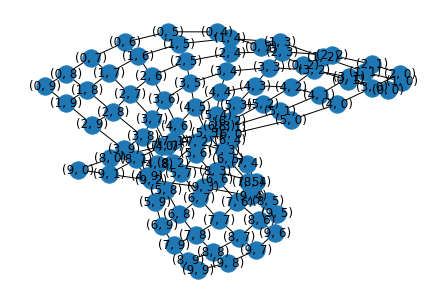

In [ ]:
import networkx as nx
G_grid=nx.grid_2d_graph(10, 10,periodic=False, create_using=None)
nx.draw(G_grid,with_labels=True)
G_=nx.convert_node_labels_to_integers(G_grid)

#Constructing GT model

In [ ]:
G_nx,tnodes=GT_model_graph(l=14,t=30)

[14, 406, 434, 826]
[(14, 1400), (406, 40600), (434, 43400), (826, 82600)]


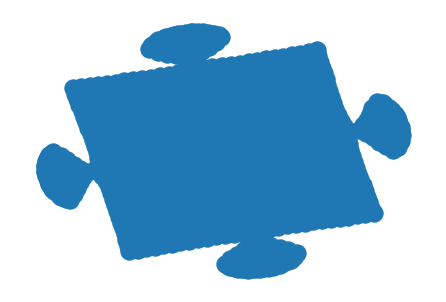

In [ ]:
nx.draw_kamada_kawai(G_nx)

In [ ]:
#taking data
nodes=G_nx.number_of_nodes()
Edges=G_nx.number_of_edges()
planar_density=Edges/(3*nodes-6)
print(planar_density,nodes,Edges)
num_walkers=5000 #number of walkers
time=10000 #number of steps taken

0.5731744576840819 1093 1876


##Computing adjacency list and a Dictionary containing degree of each node

In [ ]:
adjacency_list,node_Degree_dict=adjacency_list_nodeDegree(G_nx,nodes)

##Degree Distribution

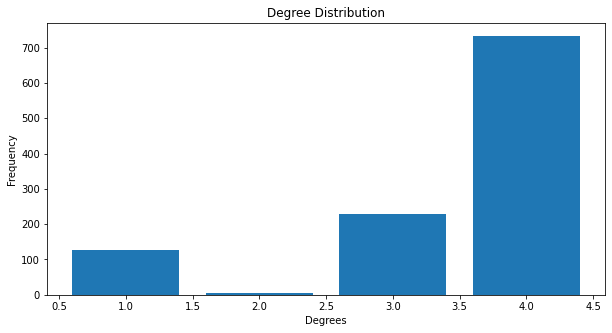

In [ ]:
Nodes_with_Degree=nodes_with_same_Degree(node_Degree_dict)
plotting_degree_distribution(Nodes_with_Degree)

In [ ]:
Nodes_with_Degree

#Creating Time Series

In [ ]:
%%time
TimeSeries_each_node_dict=DTRW_Time_Series(adjacency_list,node_Degree_dict,num_walkers,time,nodes,0)

CPU times: user 45min 17s, sys: 34.6 s, total: 45min 51s
Wall time: 45min 28s


##Saving time series in a file

In [ ]:
file_name="N_"+str(nodes)+"_E_"+str(Edges)+"_simT"+str(time)+"s_DT_walkers_"+str(num_walkers)+"_GT-model"
storeData(TimeSeries_each_node_dict,file_name)

#Retriving time series from a file

In [ ]:
TimeSeries_each_node_dict=loadData("N_1093_E_1876_simT10000s_DT_walkers_5000_GT-model")

##Plotting Time series

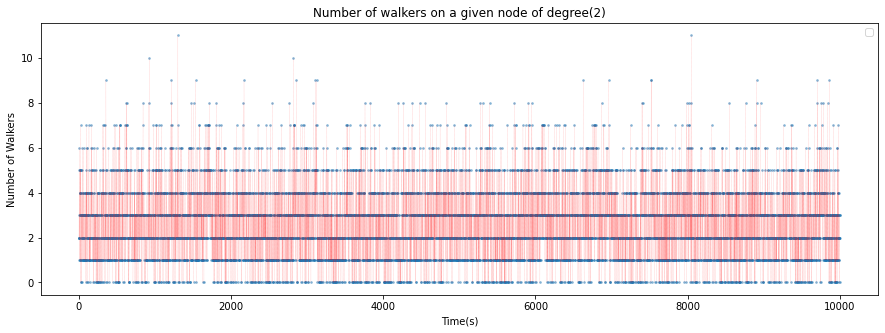

In [ ]:
node=0
plt.figure(figsize=(15,5))
xlabel,ylabel,title='Time(s)','Number of Walkers','Number of walkers on a given node of degree('+str(node_Degree_dict[node])+')'
x,y=[i for i in range(len(TimeSeries_each_node_dict[node]))],TimeSeries_each_node_dict[node]
XY_plotting(x,y,xlabel,ylabel,title,':',.1,'r')
scatter_Plot(x,y,xlabel,ylabel,title,dotsize=3,opacity=0.4,marker=".")
plt.show()

#Distribution of walkers on a node

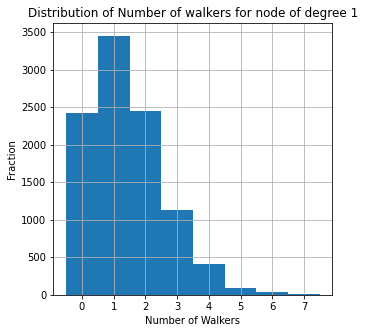

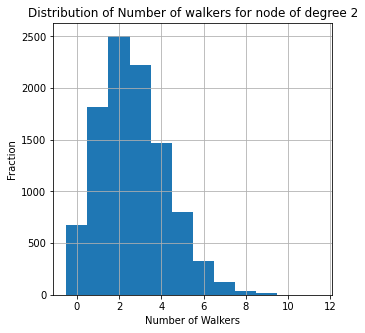

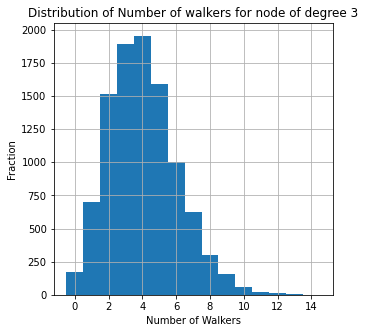

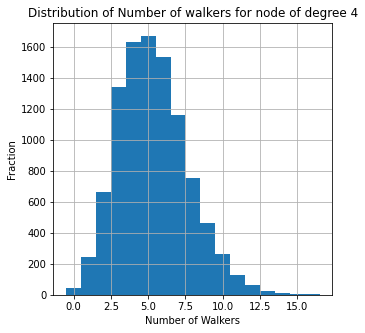

In [ ]:
for i in  Nodes_with_Degree:
  node=i[1][0]
  walkers_arr=np.array(TimeSeries_each_node_dict[node])
  bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
  fsize=(12,8)
  align='left'
  xlabel,ylabel,title="Number of Walkers","Fraction","Distribution of Number of walkers for node of degree "+str(i[0])
  HistoGram(walkers_arr,bins,False,1,xlabel,ylabel,align,title,(5,5))

##Computing average and standard deviation of walkers for each node

In [ ]:
dic_mean_walkers ,dic_std_walkers=mean_std_walkers_nodewise(TimeSeries_each_node_dict,nodes)

##Distribution of Average numbers of walkers computed for all nodes

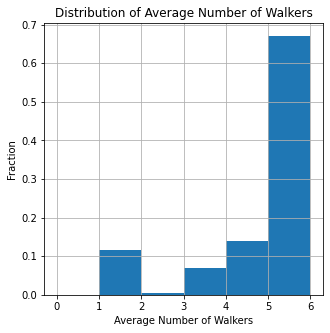

In [ ]:
mean_walkers =np.array([dic_mean_walkers[i] for i in dic_mean_walkers])
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=[i for i in range(0,int(max(mean_walkers))+2)]
xlabel,ylabel,title="Average Number of Walkers","Fraction","Distribution of Average Number of Walkers"
HistoGram(mean_walkers ,bins,True,1,xlabel,ylabel,'mid',title,(5,5))

##Distribution of Standard deviation of numbers of walkers computed for all nodes

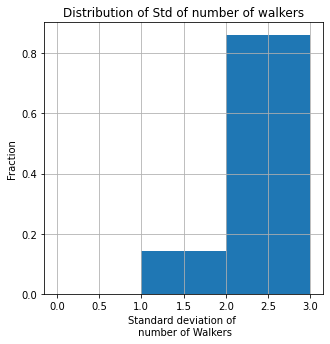

In [ ]:
std_walkers =np.array([dic_std_walkers[i] for i in dic_std_walkers])
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=[i for i in range(0,int(max(std_walkers))+2)]
fsize=(5,5)
xlabel,ylabel,title="Standard deviation of \n number of Walkers","Fraction","Distribution of Std of number of walkers"
HistoGram(std_walkers,bins,True,1,xlabel,ylabel,'mid',title,fsize)

#Variation of $\sigma$ with $<w>$ computed for all nodes

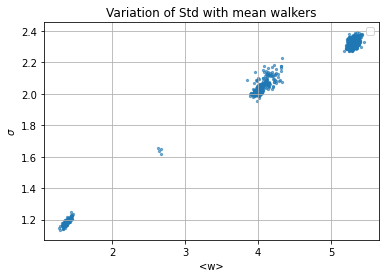

In [ ]:
xarr,yarr=np.array([dic_mean_walkers[i] for i in dic_mean_walkers]),np.array([dic_std_walkers[i] for i in dic_std_walkers])
xlabel,ylabel,title="<w>",r'$ \sigma $',"Variation of Std with mean walkers"
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=5,opacity=0.6,marker=".")

In [ ]:
Average_walkers_same_degree=[]
Std_walkers_same_degree=[]
labels=[]
for i in Nodes_with_Degree:
  x=[dic_mean_walkers[node] for node in i[1]]
  Average_walkers_same_degree.append(x)
  y=[dic_std_walkers[node] for node in i[1]]
  Std_walkers_same_degree.append(y)
  labels.append(str(i[0]))


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


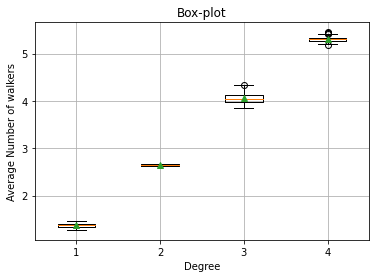

In [ ]:
xlabel,ylabel,title="Degree","Average Number of walkers","Box-plot"
xarr=Average_walkers_same_degree
Box_Plot(xarr,xlabel,ylabel,title,labels)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


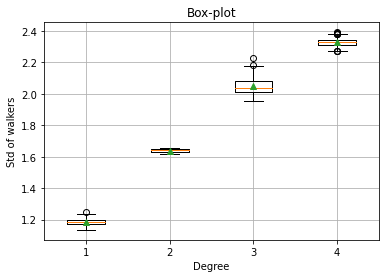

In [ ]:
xlabel,ylabel,title="Degree","Std of walkers","Box-plot"
xarr=Std_walkers_same_degree
Box_Plot(xarr,xlabel,ylabel,title,labels)

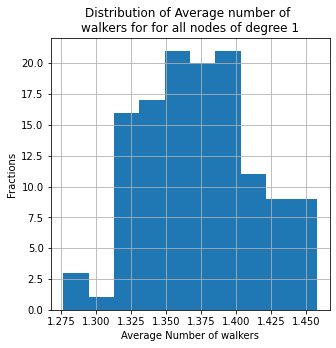

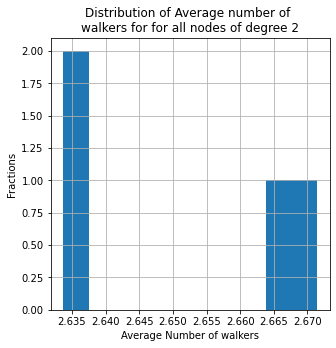

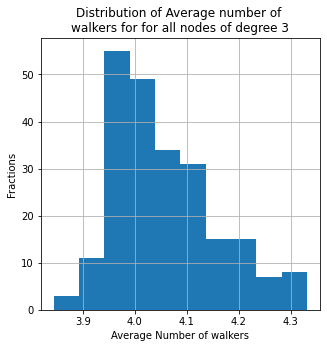

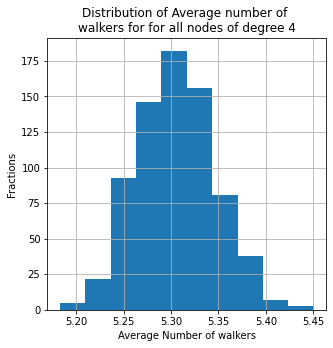

In [ ]:
xlabel,ylabel,title="Average Number of walkers","Fractions","Distribution of Average number of \nwalkers for for all nodes of degree "
for i,j in enumerate(Average_walkers_same_degree):
  bins=10
  HistoGram(j,bins,False,1,xlabel,ylabel,'mid',title+str(i+1),(5,5))

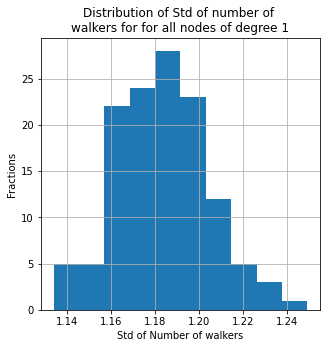

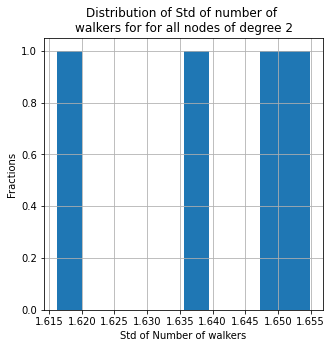

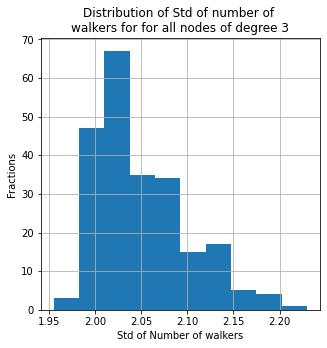

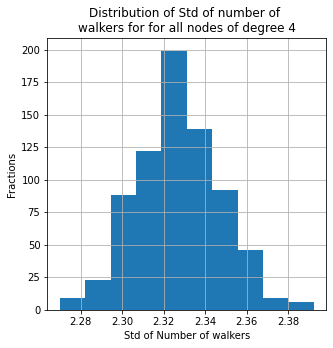

In [ ]:
xlabel,ylabel,title="Std of Number of walkers","Fractions","Distribution of Std of number of \nwalkers for for all nodes of degree "
for i,j in enumerate(Std_walkers_same_degree):
  bins=10
  HistoGram(j,bins,False,1,xlabel,ylabel,'mid',title+str(i+1),(5,5))

##Computing average and standard deviation of walkers degreewise

In [ ]:
Average_walk_degreewise,Std_walk_degreewise=walkers_statistic_degreewise(Nodes_with_Degree,dic_mean_walkers,dic_std_walkers)

##Distribution of Average numbers of walkers (Computed degreewise)

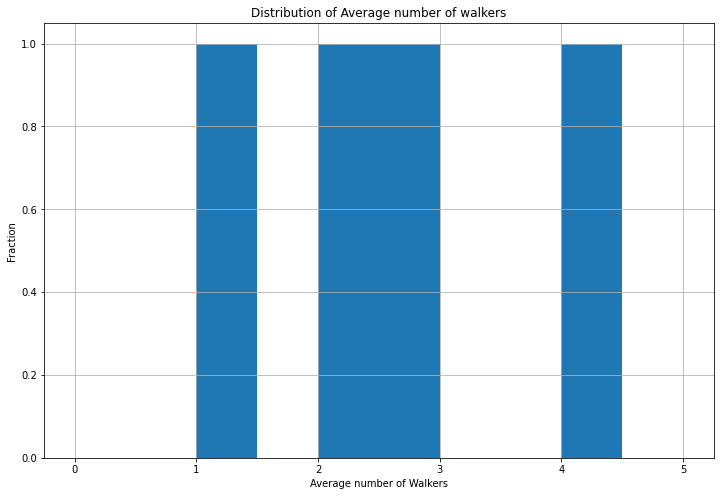

In [ ]:
Avg_walkers =np.array(Average_walk_degreewise)
Avg_walkers_only=Avg_walkers[::,1]
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=[0,0.5,1.0,1.5,2.0,3,3.5,4.0,4.5,5.0]
fsize=(12,8)
xlabel,ylabel,title="Average number of Walkers","Fraction","Distribution of Average number of walkers"
HistoGram(Avg_walkers_only,bins,False,1,xlabel,ylabel,'mid',title,fsize)

##**Variation of average number of walkers with degree of nodes**

scaling= 1.3594362953902985 exponent= 0.9840847271398635 shifting= 0.003324563477639285


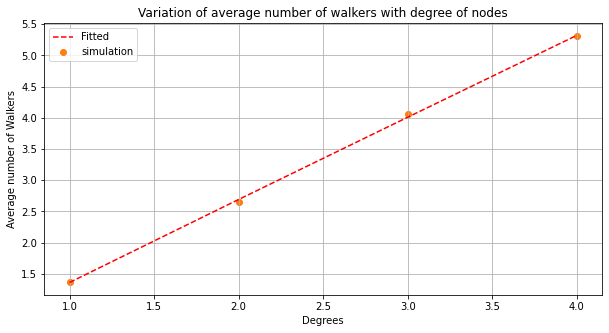

In [ ]:
xarr,yarr=Avg_walkers[::,0],Avg_walkers[::,1]
fig=plt.figure(figsize=(10,5))
xlabel="Degrees"
ylabel="Average number of Walkers"
title="Variation of average number of walkers with degree of nodes"
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=25,opacity=1,marker="o")
curve_fitting(xarr,yarr)

##Distribution of standard deviation of numbers of walkers(computed degreewise)
Here, I am plotting the distribution of numbers of walkers average over degree of nodes.

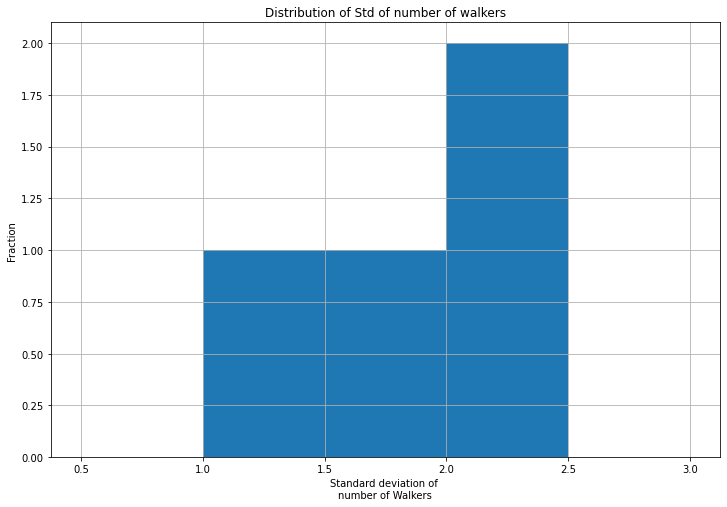

In [ ]:
Std_walkers =np.array(Std_walk_degreewise)
Std_walkers_only=Std_walkers[::,1]
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=[0.5, 1.0,1.5,2.0,2.5,3.0 ]
fsize=(12,8)
xlabel,ylabel,title="Standard deviation of \nnumber of Walkers","Fraction","Distribution of Std of number of walkers"
HistoGram(Std_walkers_only,bins,False,1,xlabel,ylabel,'mid',title,fsize)

##**Variation of Std of number of walkers with degree of nodes**

scaling= 1.1305724511654682 exponent= 0.5086477203291695 shifting= 0.049019803912086615


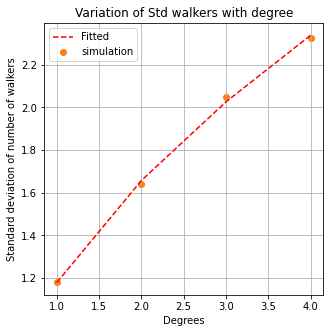

In [ ]:
xarr,yarr=Std_walkers[::,0],Std_walkers[::,1]
fig=plt.figure(figsize=(5,5))
xlabel="Degrees"
ylabel="Standard deviation of number of walkers"
title="Variation of Std walkers with degree"
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=25,opacity=0.8,marker="o")
curve_fitting(xarr,yarr)

##**Variation of Average number of walkers with standard deviation**

scaling= 1.0368404370446984 exponent= 0.4937635618162855 shifting= -0.031133513833684845


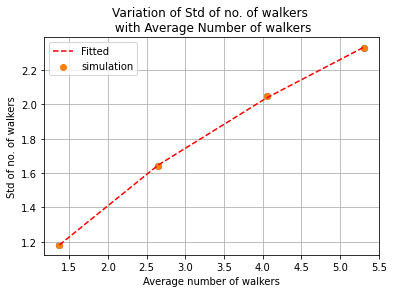

In [ ]:
xarr=Avg_walkers_only
yarr=Std_walkers_only
xlabel,ylabel,title="Average number of walkers","Std of no. of walkers","Variation of Std of no. of walkers \n with Average Number of walkers"
labels="Variation"
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=40,opacity=0.8,marker="o")
curve_fitting(xarr,yarr)

#Extreme Event Probablity Computation and plotting

In [ ]:
Scaling_factor=2
threshold_dict,EEP_nodewise,EEP_degreewise=ExtremeEventProb(nodes,Nodes_with_Degree,Scaling_factor,TimeSeries_each_node_dict,dic_mean_walkers,dic_std_walkers)

##Distribution of threshold values computed for all nodes

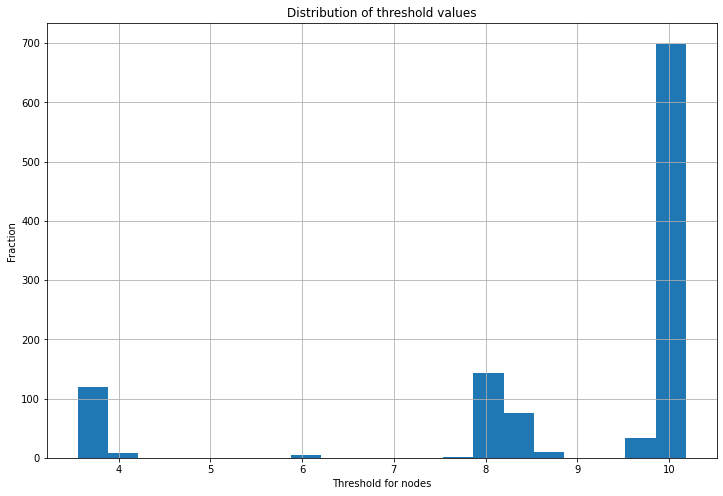

In [ ]:
threshold_values=np.array([threshold_dict[i] for i in threshold_dict])
bins=20
xlabel,ylabel,title="Threshold for nodes","Fraction","Distribution of threshold values"
HistoGram(threshold_values,bins,False,1,xlabel,ylabel,'mid',title,fsize)

##Distribution of Probability of Extreme event values(computed for all nodes)

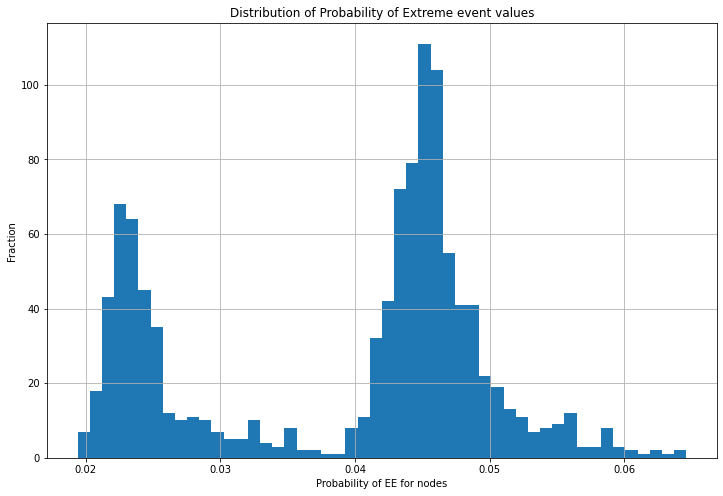

In [ ]:
ExtremeEventN_values=np.array([EEP_nodewise[i] for i in EEP_nodewise])
bins=50
xlabel,ylabel,title="Probability of EE for nodes","Fraction","Distribution of Probability of Extreme event values"
HistoGram(ExtremeEventN_values,bins,False,1,xlabel,ylabel,'mid',title,fsize)

##Distribution of Probability of Extreme event values average over nodes of same degree

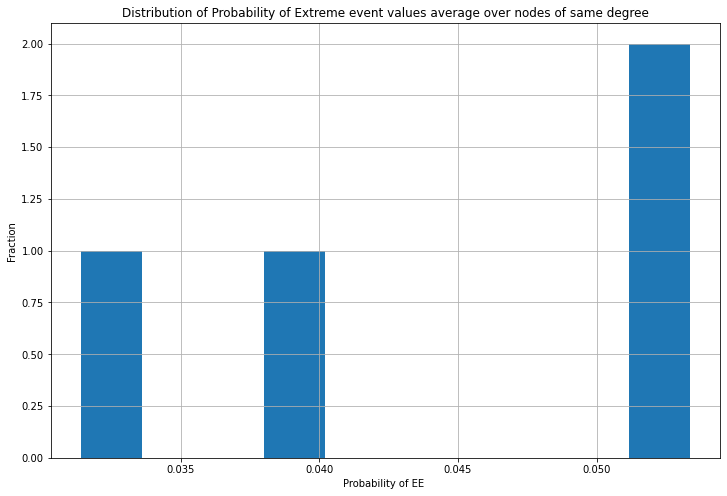

In [ ]:
ExtremeEventD_values=np.array([EEP_degreewise[i] for i in EEP_degreewise])
bins=10
xlabel,ylabel,title="Probability of EE ","Fraction","Distribution of Probability of Extreme event values average over nodes of same degree"
HistoGram(ExtremeEventD_values,bins,False,1,xlabel,ylabel,'mid',title,fsize)

In [ ]:
ExtremeEventD_values

array([0.05257266, 0.05335   , 0.03141053, 0.03923834])

##Variation of Probability of Occurrence of extreme event with degree of nodes

Text(0.5, 0, 'Degrees')

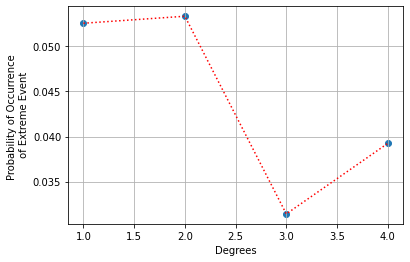

In [ ]:
extreme_eventP_degreewise=np.array([[j,EEP_degreewise[j]] for j in EEP_degreewise])
xarr,yarr=extreme_eventP_degreewise[::,0],extreme_eventP_degreewise[::,1]
plt.scatter(xarr,yarr)
plt.plot(xarr,yarr,color='r',ls=':')
plt.ylabel("Probability of Occurrence \n of Extreme Event")
plt.grid()
plt.xlabel("Degrees")

#Semi-Analytical calculation of probability of Occurence of Extreme Event

##Computing occupation probability

In [ ]:
occup_prob_nodewise_dict=occupation_prob(node_Degree_dict)

##Computing

In [ ]:
EE_prob_analytical_nodewise_dict,EE_prob_analytical_degreewise_dict=EE_prob_analytical(Nodes_with_Degree,threshold_dict,occup_prob_nodewise_dict,5000,nodes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


#Computing Recurrence Time Interval

In [ ]:
recurrence_Time_each_node=Extreme_Event_recurrenceTime_eachnode(nodes,TimeSeries_each_node_dict,threshold_values)

##Distribution of recurrence time interval for a node

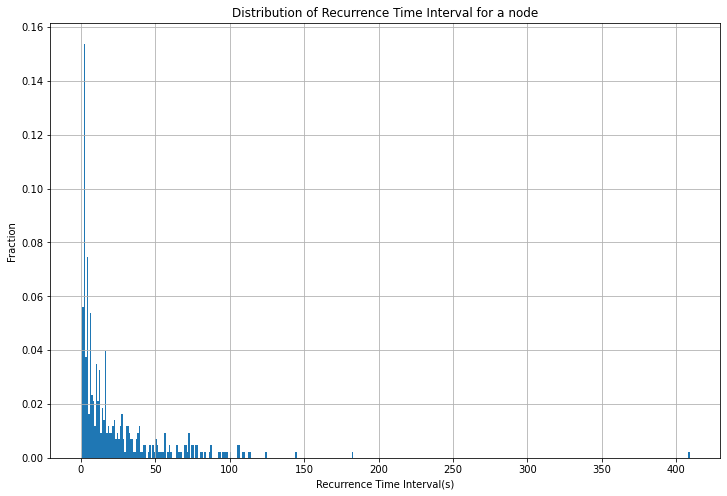

In [ ]:
node=56
mean_walkers =np.array(recurrence_Time_each_node[node])
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=[i for i in range(0,int(max(mean_walkers))+2)]
fsize=(12,8)
xlabel,ylabel,title="Recurrence Time Interval(s)","Fraction","Distribution of Recurrence Time Interval for a node"
HistoGram(mean_walkers ,bins,True,1,xlabel,ylabel,'mid',title,fsize)

##Computing average recurrence time for each node and also degreewise

In [ ]:
average_recurrenceT_nodewise,average_recurrenceT_degreewise=Average_recurrenceTime__Node_Degreewise(nodes,Nodes_with_Degree,recurrence_Time_each_node)

##Distribution of Average Recurrence Time Interval computed for all nodes

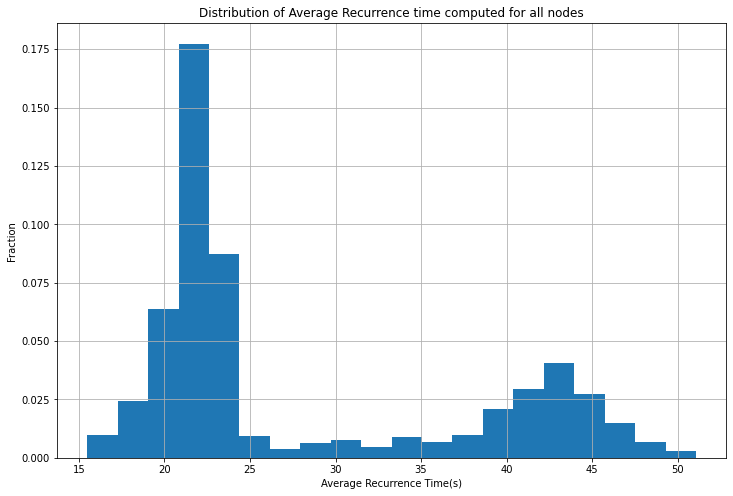

In [ ]:
RecurrenecTime_values_all_nodes=[average_recurrenceT_nodewise[i] for i in average_recurrenceT_nodewise]
bins=20
fsize=(12,8)
xlabel,ylabel,title="Average Recurrence Time(s)","Fraction","Distribution of Average Recurrence time computed for all nodes"
HistoGram(RecurrenecTime_values_all_nodes ,bins,True,1,xlabel,ylabel,'mid',title,fsize)

##Distribution of recurrence time interval computed degreewise

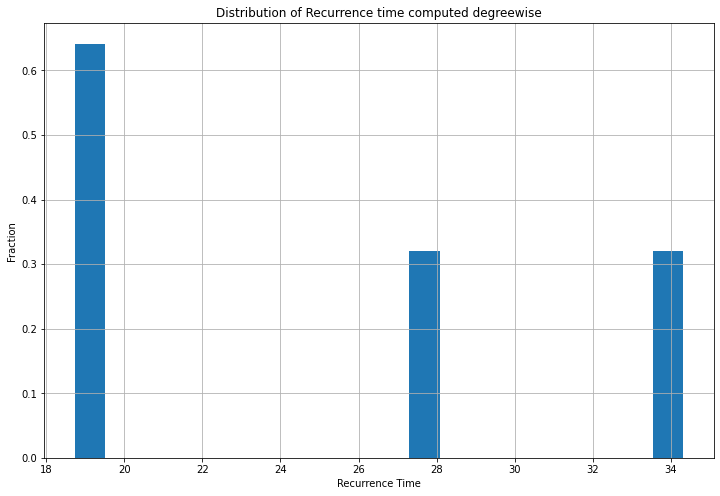

In [ ]:
RecurrenecTime_values_degreewise=[average_recurrenceT_degreewise[i] for i in average_recurrenceT_degreewise]
bins=20
fsize=(12,8)
xlabel,ylabel,title="Average Recurrence Time(s)","Fraction","Distribution of Recurrence time computed degreewise"
HistoGram(RecurrenecTime_values_degreewise ,bins,True,1,xlabel,ylabel,'mid',title,fsize)

##Variation of Average recurrence time interval with degree

Text(0.5, 0, 'Degrees')

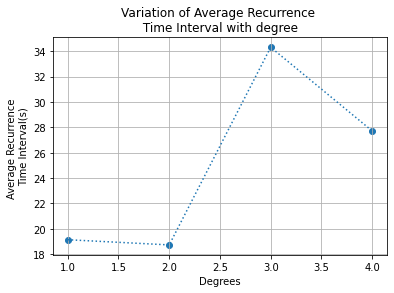

In [ ]:
RecurrenecTime_values_degreewise=np.array([[j,average_recurrenceT_degreewise[j]] for j in average_recurrenceT_degreewise])
xarr,yarr=RecurrenecTime_values_degreewise[::,0],RecurrenecTime_values_degreewise[::,1]
plt.scatter(xarr,yarr)
plt.plot(xarr,yarr,ls=':')
plt.ylabel("Average Recurrence \nTime Interval(s)")
plt.title("Variation of Average Recurrence \n Time Interval with degree ")
plt.grid()
plt.xlabel("Degrees")

#Computing magnitude of difference of Extreme Event

In [ ]:
nodewise_EE_abs_diff_dict=Absolute_diff_mag_EE(nodes,TimeSeries_each_node_dict,threshold_dict)

##Distribution of magnitude of difference of Extreme Events for a node

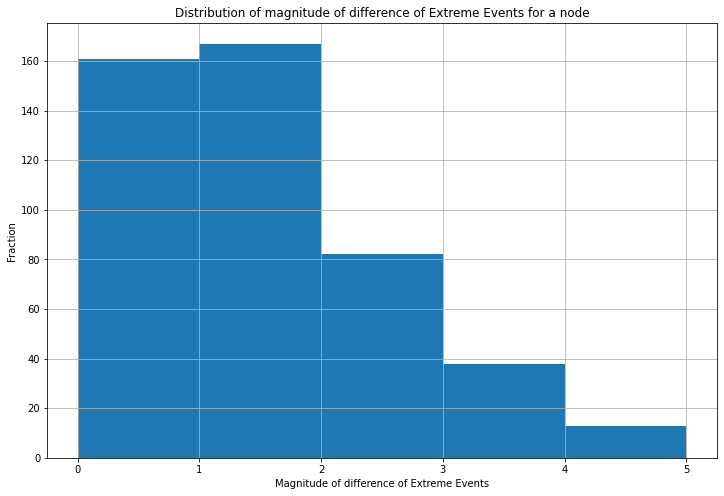

In [ ]:
EE_abs_diff_values_for_a_node=nodewise_EE_abs_diff_dict[44]
fsize=(12,8)
bins=[0,1,2,3,4,5]
xlabel,ylabel,title="Magnitude of difference of Extreme Events","Fraction","Distribution of Magnitude of Difference of Extreme Events for a node"
HistoGram(EE_abs_diff_values_for_a_node ,bins,False,1,xlabel,ylabel,'mid',title,fsize)

##Computing Average magnitude of Extreme event difference nodewise and degreewise

In [ ]:
average_abs_diff_mag_EE_nodewise,average_abs_diff_mag_EE_degreewise=Average_Absolute_diff_mag_EE__Node_Degreewise(nodes,Nodes_with_Degree,nodewise_EE_abs_diff_dict)

##Distribution of Average magnitude of difference of Extreme Events computed for all nodes

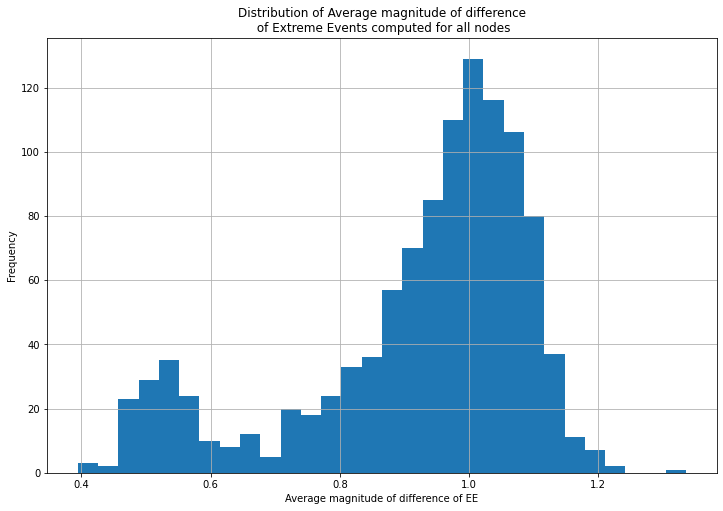

In [ ]:
average_abs_diff_mag_EE_all_nodes=[average_abs_diff_mag_EE_nodewise[i]for i in average_abs_diff_mag_EE_nodewise]
fsize=(12,8)
bins=30
xlabel,ylabel,title="Average Magnitude of difference of EE","Frequency","Distribution of Average magnitude of difference\n of Extreme Events computed for all nodes"
HistoGram(average_abs_diff_mag_EE_all_nodes ,bins,False,1,xlabel,ylabel,'mid',title,fsize)

In [ ]:
average_abs_diff_mag_EE_degreewise

{1: 0.5252857130981105,
 2: 0.7303177462513297,
 3: 0.8465943074768147,
 4: 1.0148556451963184}

##Variation of Average Magnitude of difference of Extreme Event with degree

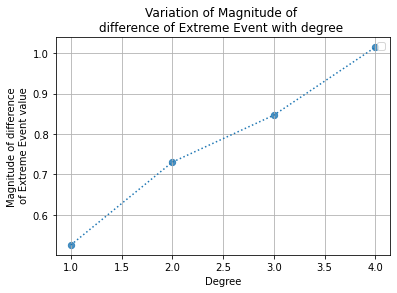

In [ ]:
average_abs_diff_mag_EE_degreewise_array=np.array([[j,average_abs_diff_mag_EE_degreewise[j]]for j in average_abs_diff_mag_EE_degreewise])
xarr,yarr=average_abs_diff_mag_EE_degreewise_array[::,0],average_abs_diff_mag_EE_degreewise_array[::,1]
xlabel,ylabel,title="Degree","Magnitude of Difference\n of Extreme Event value","Variation of Magnitude of \ndifference of Extreme Event with degree "
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=40,opacity=0.8,marker="o")
plt.plot(xarr,yarr,ls=':')